# Imports

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
%matplotlib inline

# Data
After reading in data, we also need to separate the `location` variable into its corresponding latitude and longitude coordinates.

In [26]:
# Read in data
data = pd.read_json('../data_json/traffic_data.zip', orient='index', convert_axes=False)
# orient --> indicates expected json string format, we're oriented on the indicies
# convert_axis --> to stop from labeling index (accident id) as datetime

data.head()

,Area ID,Premise Description,Location,month,day,year,hour,day_category
100100007,1,STREET,"(34.0395, -118.2656)",11,8,2010,22,night
100100767,1,STREET,"(34.0695, -118.2324)",3,31,2010,4,night
100100831,1,STREET,"(34.0424, -118.2718)",4,18,2010,1,night
100101004,1,STREET,"(34.0344, -118.2714)",6,5,2010,20,night
100101322,1,STREET,"(34.0637, -118.2361)",8,7,2010,16,evening


In [27]:
data.info() # get datatypes of various objects

<class 'pandas.core.frame.DataFrame'>
Index: 570372 entries, 100100007 to 222104964
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Area ID              570372 non-null  int64 
 1   Premise Description  570372 non-null  object
 2   Location             570372 non-null  object
 3   month                570372 non-null  int64 
 4   day                  570372 non-null  int64 
 5   year                 570372 non-null  int64 
 6   hour                 570372 non-null  int64 
 7   day_category         570372 non-null  object
dtypes: int64(5), object(3)
memory usage: 39.2+ MB


## Change mis-categorized variables
- we are treating Area Id, month, day, year, hour as categories (e.g. dtype=object) even though they were initially categorized as integers.

In [28]:
def change_to_cat(df, col):
    """Function to change columns to type object (categorical)"""
    
    df[col] = df[col].astype('object')
    return df

In [29]:
cols_to_change = ['Area ID', 'Premise Description', 'month', 'day', 'year', 'hour', 'day_category']

for col in cols_to_change:
    data = change_to_cat(data, col)

data.info() # correctly changed all categorical variables to object

<class 'pandas.core.frame.DataFrame'>
Index: 570372 entries, 100100007 to 222104964
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Area ID              570372 non-null  object
 1   Premise Description  570372 non-null  object
 2   Location             570372 non-null  object
 3   month                570372 non-null  object
 4   day                  570372 non-null  object
 5   year                 570372 non-null  object
 6   hour                 570372 non-null  object
 7   day_category         570372 non-null  object
dtypes: object(8)
memory usage: 39.2+ MB


## Convert location into lat/long coordinates

In [30]:
def get_latitude(loc):
    lat, _, _ = loc.partition(',')
    lat = lat.replace('(', '')

    return float(lat)

def get_longitude(loc):
    _, _, long = loc.partition(',')
    long = long.replace(')', '')

    return float(long)

In [31]:
data['lat'] = data.Location.apply(get_latitude)
data['long'] = data.Location.apply(get_longitude)
data.drop(columns='Location', inplace=True)
data[['lat', 'long']].head()

,lat,long
100100007,34.0395,-118.2656
100100767,34.0695,-118.2324
100100831,34.0424,-118.2718
100101004,34.0344,-118.2714
100101322,34.0637,-118.2361


In [32]:
# Filter out coordinates that fall outside the rough range of Los Angeles
data = data[(data['lat'] <= 36) & (data['long'] <= -110)] 

# Cluster Analysis

In [58]:
def hist_plot(data_red, col):
    sns.histplot(data_red, x=col)
    plt.show()

In [64]:
def evaluate_clusters(cltrs):
    """Analysis where clstrs refer to dataframes split based on cluster label"""
    for i, cluster in enumerate(cltrs):
        print(f'Cluster: {i}')
        print('----------------')
        for col in cluster.columns:
            print(f'Column: {col}')
            print('------------------------')
            if col == 'Premise Description':
                print(cluster[col].value_counts())
            
            elif col == 'label':
                pass
            
            else:
                hist_plot(cluster, col)

            print()

# 1st Clustering Approach - Kmodes
Because the majority of our data is categorical, we have chosen to explore the kmodes clustering implementation which uses a different dissimlarity measure and utilizes the most frequent category (mode) instead of the mean.

## Binning Location coordinates
Since our approach is kmodes we need to convert all of our variables into categorical. Our only true numeric variable is latitude and longitude, so we are interested in binning these locations to perform kmodes.

**I was having confusion binning a value with two entries corresponding to latitude/longitude --> wouldn't we lose information binning these separately**

<AxesSubplot:xlabel='lat', ylabel='Count'>

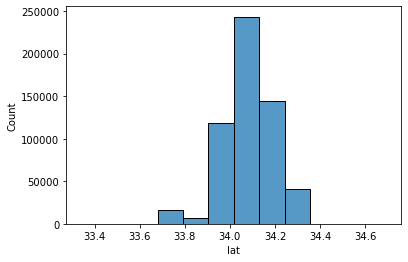

In [9]:
sns.histplot(data=data, x='lat', bins=12)

# 2nd Clustering Approach --> K-Prototypes (mix between K-means and K-modes)

In [33]:
data.head()

,Area ID,Premise Description,month,day,year,hour,day_category,lat,long
100100007,1,STREET,11,8,2010,22,night,34.0395,-118.2656
100100767,1,STREET,3,31,2010,4,night,34.0695,-118.2324
100100831,1,STREET,4,18,2010,1,night,34.0424,-118.2718
100101004,1,STREET,6,5,2010,20,night,34.0344,-118.2714
100101322,1,STREET,8,7,2010,16,evening,34.0637,-118.2361


In [44]:
cat_cols = [0, 1, 2, 3, 4, 5, 6]  # corresponds to all variables other than lat/long

In [45]:
# Takes roughly 24 minutes to run on my machine

dfmatrix = data.to_numpy()
kproto = KPrototypes(n_clusters=3, init='Huang', n_jobs=-1)

clusters = kproto.fit_predict(dfmatrix, categorical=cat_cols)
labeled_data = data.copy()
labeled_data['label'] = clusters

labeled_data.head()


,Area ID,Premise Description,month,day,year,hour,day_category,lat,long,label
100100007,1,STREET,11,8,2010,22,night,34.0395,-118.2656,0
100100767,1,STREET,3,31,2010,4,night,34.0695,-118.2324,0
100100831,1,STREET,4,18,2010,1,night,34.0424,-118.2718,0
100101004,1,STREET,6,5,2010,20,night,34.0344,-118.2714,0
100101322,1,STREET,8,7,2010,16,evening,34.0637,-118.2361,0


In [48]:
kproto.cluster_centroids_

array([['34.04996668767997', '-118.3273640969244', '12', 'STREET', '10',
        '3', '2014', '19', 'night'],
       ['34.110094489233084', '-118.40159283214841', '8', 'STREET', '7',
        '26', '2012', '13', 'afternoon'],
       ['34.096211816204345', '-118.37368973559157', '10', 'STREET', '6',
        '23', '2017', '10', 'morning']], dtype='<U32')

In [50]:
# Give a general description of mode/mean for variables of different clusters
labeled_data.groupby('label').agg(
    {
        'Area ID': lambda x: x.value_counts().index[0],
        'Premise Description': lambda x: x.value_counts().index[0],
        'month': lambda x: x.value_counts().index[0],
        'day': lambda x: x.value_counts().index[0],
        'year': lambda x: x.value_counts().index[0],
        'hour': lambda x: x.value_counts().index[0],
        'day_category': lambda x: x.value_counts().index[0],
        'lat': 'mean',
        'long': 'mean'
    }
).reset_index()

,label,Area ID,Premise Description,month,day,year,hour,day_category,lat,long
0,0,12,STREET,10,3,2014,19,night,34.049967,-118.327364
1,1,8,STREET,7,26,2012,13,afternoon,34.110094,-118.401593
2,2,10,STREET,6,23,2017,10,morning,34.096212,-118.373690


## Evaluation

In [62]:
clusters = [labeled_data[labeled_data.label == label] for label in [0, 1, 2]]

Cluster: 0
----------------
Column: Area ID
------------------------


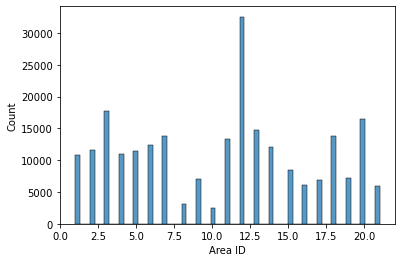


Column: Premise Description
------------------------
STREET                                                 228148
PARKING LOT                                              6554
SIDEWALK                                                 1585
ALLEY                                                     453
DRIVEWAY                                                  451
                                                        ...  
BUS-CHARTER/PRIVATE                                         1
SEX ORIENTED/BOOK STORE/STRIP CLUB/GENTLEMAN'S CLUB         1
NAIL SALON                                                  1
MANUFACTURING COMPANY                                       1
MEDICAL MARIJUANA FACILITIES/BUSINESSES                     1
Name: Premise Description, Length: 83, dtype: int64

Column: month
------------------------


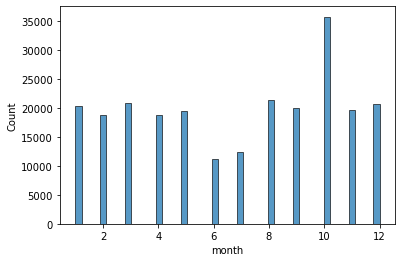


Column: day
------------------------


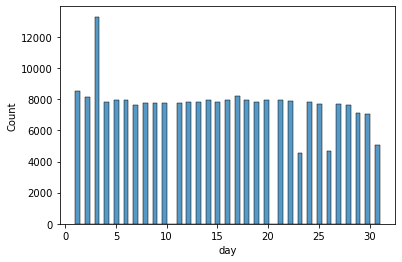


Column: year
------------------------


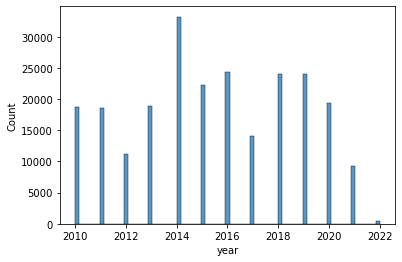


Column: hour
------------------------


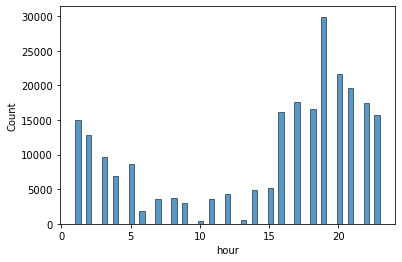


Column: day_category
------------------------


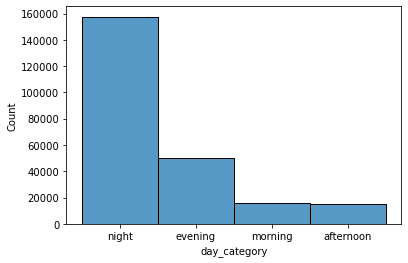


Column: lat
------------------------


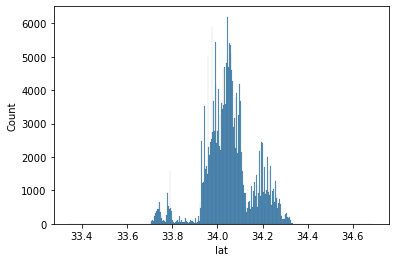


Column: long
------------------------


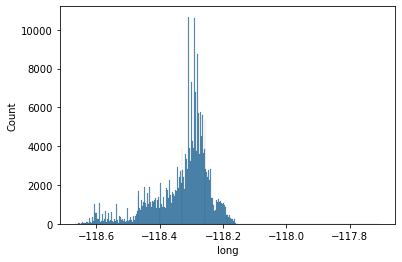


Column: label
------------------------

Cluster: 1
----------------
Column: Area ID
------------------------


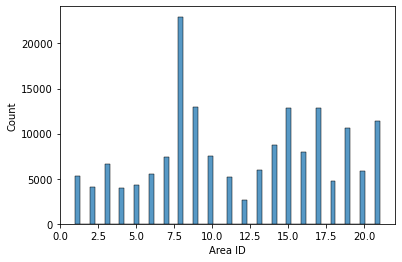


Column: Premise Description
------------------------
STREET              160706
PARKING LOT           6358
SIDEWALK               660
                       330
ALLEY                  274
                     ...  
PAWN SHOP                1
WAREHOUSE                1
RECYCLING CENTER         1
LIBRARY                  1
AUTO REPAIR SHOP         1
Name: Premise Description, Length: 75, dtype: int64

Column: month
------------------------


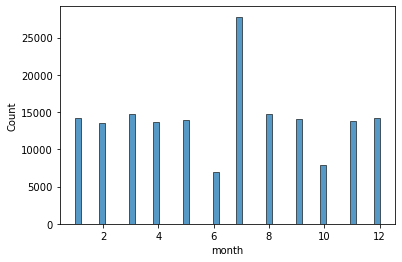


Column: day
------------------------


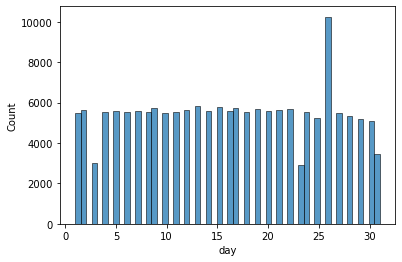


Column: year
------------------------


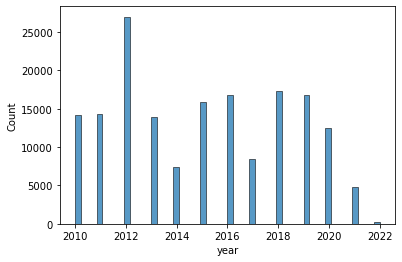


Column: hour
------------------------


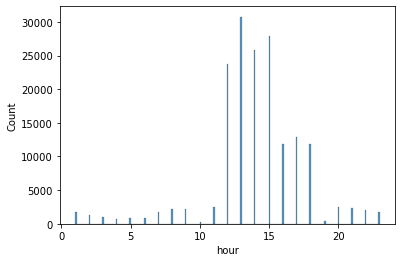


Column: day_category
------------------------


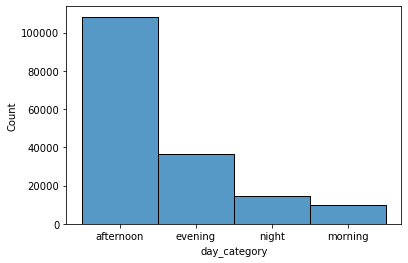


Column: lat
------------------------


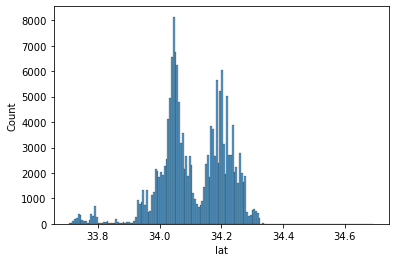


Column: long
------------------------


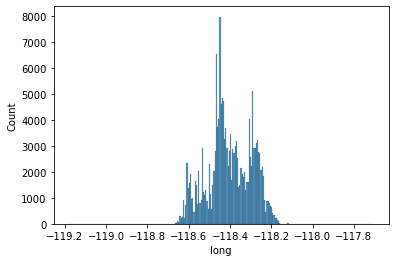


Column: label
------------------------

Cluster: 2
----------------
Column: Area ID
------------------------


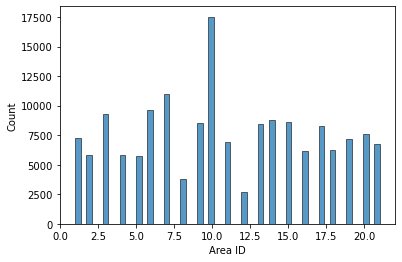


Column: Premise Description
------------------------
STREET                                     154404
PARKING LOT                                  5108
SIDEWALK                                      811
ALLEY                                         288
DRIVEWAY                                      285
                                            ...  
AIRCRAFT                                        1
BUS-CHARTER/PRIVATE                             1
ENTERTAINMENT/COMEDY CLUB (OTHER)               1
CONSTRUCTION SITE                               1
MEDICAL MARIJUANA FACILITIES/BUSINESSES         1
Name: Premise Description, Length: 79, dtype: int64

Column: month
------------------------


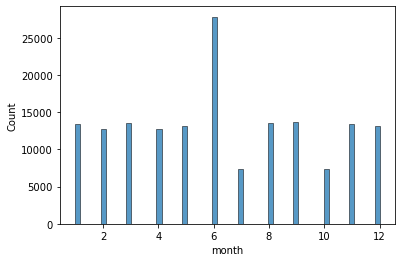


Column: day
------------------------


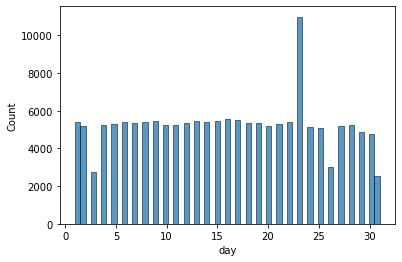


Column: year
------------------------


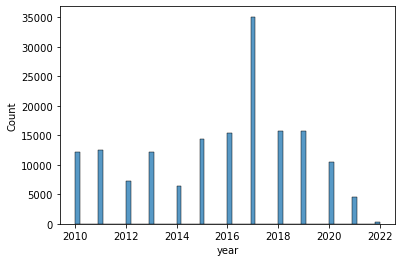


Column: hour
------------------------


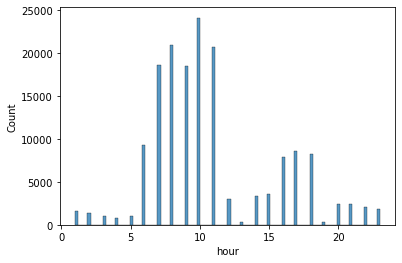


Column: day_category
------------------------


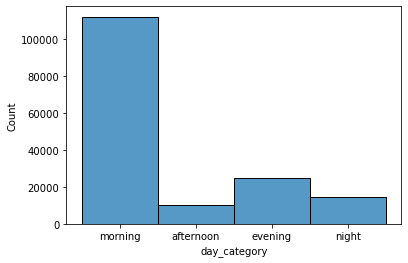


Column: lat
------------------------


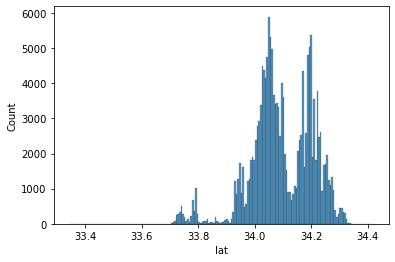


Column: long
------------------------


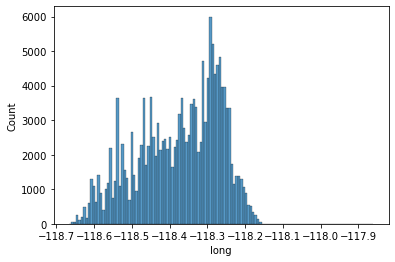


Column: label
------------------------



In [65]:
evaluate_clusters(cltrs=clusters)

### Scratch

<AxesSubplot:xlabel='long', ylabel='lat'>

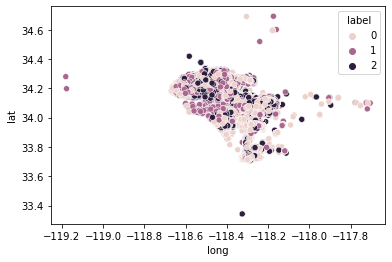

In [53]:
sns.scatterplot(data=labeled_data, x='long', y='lat', hue='label')

# 3rd Clustering Approach --> Kmeans with One Hot Encoding

In [9]:
cat_cols = ['Area ID', 'Premise Description', 'month', 'day', 'year', 'hour', 'day_category']
data_enc = pd.get_dummies(data, columns=cat_cols)
data_enc.head()

,lat,long,Area ID_1,Area ID_2,Area ID_3,Area ID_4,Area ID_5,Area ID_6,Area ID_7,Area ID_8,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_category_afternoon,day_category_evening,day_category_morning,day_category_night
100100007,34.0395,-118.2656,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
100100767,34.0695,-118.2324,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
100100831,34.0424,-118.2718,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
100101004,34.0344,-118.2714,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
100101322,34.0637,-118.2361,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
kmeans = KMeans(3)
clusters = kmeans.fit_predict(data_enc)
labels = pd.DataFrame(clusters)
data_labeled = data.copy()
data_labeled['labels'] = labels.values
# data_labeled = pd.concat((data, labels), axis=1)
# data_labeled = data_labeled.rename({0: 'label'}, axis=1)

data_labeled

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


,Area ID,Premise Description,month,day,year,hour,day_category,lat,long,labels
100100007,1,STREET,11,8,2010,22,night,34.0395,-118.2656,2
100100767,1,STREET,3,31,2010,4,night,34.0695,-118.2324,2
100100831,1,STREET,4,18,2010,1,night,34.0424,-118.2718,2
100101004,1,STREET,6,5,2010,20,night,34.0344,-118.2714,2
100101322,1,STREET,8,7,2010,16,evening,34.0637,-118.2361,1
...,...,...,...,...,...,...,...,...,...,...
222104843,21,STREET,1,26,2022,19,night,34.1857,-118.5710,2
222104874,21,STREET,1,24,2022,15,afternoon,34.1938,-118.6059,0
222104886,21,STREET,1,24,2022,17,evening,34.1740,-118.5888,1
222104962,21,STREET,1,28,2022,19,night,34.1624,-118.6285,2


<AxesSubplot:xlabel='long', ylabel='lat'>

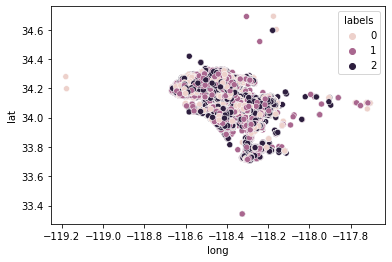

In [ ]:
sns.scatterplot(data=data_labeled, x='long', y='lat', hue='labels')

In [ ]:
l0 = data_labeled[data_labeled.labels == 0]
l1 = data_labeled[data_labeled.labels == 1]
l2 = data_labeled[data_labeled.labels == 2]

In [ ]:
l0

,Area ID,Premise Description,month,day,year,hour,day_category,lat,long,labels
100104017,1,STREET,1,1,2010,12,afternoon,34.0453,-118.2651,0
100104019,1,STREET,1,1,2010,14,afternoon,34.0503,-118.2504,0
100104026,1,STREET,1,1,2010,15,afternoon,34.0371,-118.2551,0
100104126,1,STREET,1,3,2010,14,afternoon,34.0531,-118.2478,0
100104222,1,STREET,1,5,2010,13,afternoon,34.0396,-118.2558,0
...,...,...,...,...,...,...,...,...,...,...
222104641,21,STREET,1,20,2022,13,afternoon,34.2194,-118.6235,0
222104668,21,STREET,1,21,2022,12,afternoon,34.1710,-118.5709,0
222104792,21,STREET,1,25,2022,15,afternoon,34.1658,-118.6008,0
222104874,21,STREET,1,24,2022,15,afternoon,34.1938,-118.6059,0


In [ ]:
l0.day_category.unique()

array(['afternoon'], dtype=object)

## Now try removing day_category to see the results

In [13]:
data2 = data.drop(columns='day_category')
data2.head()

,Area ID,Premise Description,month,day,year,hour,lat,long
100100007,1,STREET,11,8,2010,22,34.0395,-118.2656
100100767,1,STREET,3,31,2010,4,34.0695,-118.2324
100100831,1,STREET,4,18,2010,1,34.0424,-118.2718
100101004,1,STREET,6,5,2010,20,34.0344,-118.2714
100101322,1,STREET,8,7,2010,16,34.0637,-118.2361


In [19]:
cat_cols = ['Area ID', 'Premise Description', 'month', 'day', 'year', 'hour']
data_enc = pd.get_dummies(data2, columns=cat_cols)

In [20]:
kmeans = KMeans(3)
labels = kmeans.fit_predict(data_enc)
data_labeled = data2.copy()

data_labeled['label'] = labels


In [21]:
c0 = data_labeled[data_labeled.label == 0]
c1 = data_labeled[data_labeled.label == 1]
c2 = data_labeled[data_labeled.label == 2]

Cluster: 0
----------------
Column: Area ID
------------------------


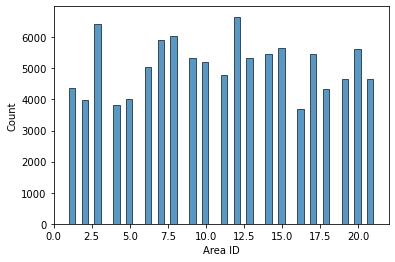

Column: Premise Description
------------------------
STREET                                  102312
PARKING LOT                               2818
SIDEWALK                                   448
ALLEY                                      167
DRIVEWAY                                   146
                                         ...  
NAIL SALON                                   1
NURSING/CONVALESCENT/RETIREMENT HOME         1
SLIPS/DOCK/MARINA/BOAT                       1
TUNNEL                                       1
HOTEL                                        1
Name: Premise Description, Length: 63, dtype: int64
Column: month
------------------------


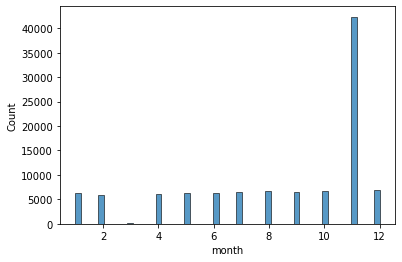

Column: day
------------------------


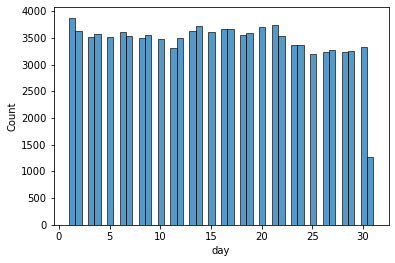

Column: year
------------------------


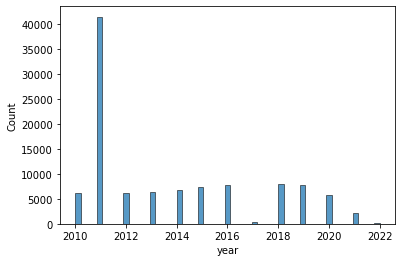

Column: hour
------------------------


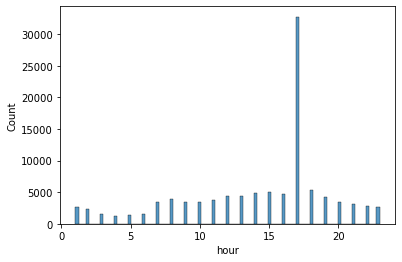

Column: lat
------------------------


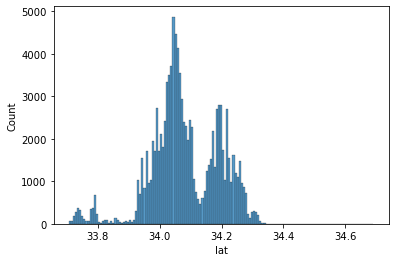

Column: long
------------------------


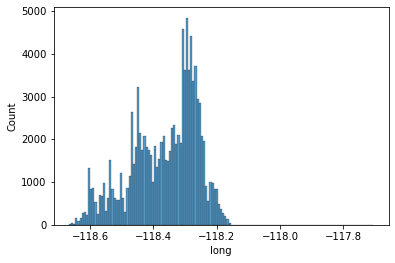

Column: label
------------------------
Cluster: 1
----------------
Column: Area ID
------------------------


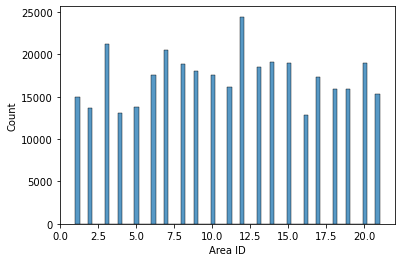

Column: Premise Description
------------------------
STREET                                                       345044
PARKING LOT                                                   11890
SIDEWALK                                                       2097
ALLEY                                                           683
DRIVEWAY                                                        638
                                                              ...  
TV/RADIO/APPLIANCE                                                1
MOBILE HOME/TRAILERS/CONSTRUCTION TRAILERS/RV'S/MOTORHOME         1
BUS, SCHOOL, CHURCH                                               1
LIBRARY                                                           1
AUTO REPAIR SHOP                                                  1
Name: Premise Description, Length: 99, dtype: int64
Column: month
------------------------


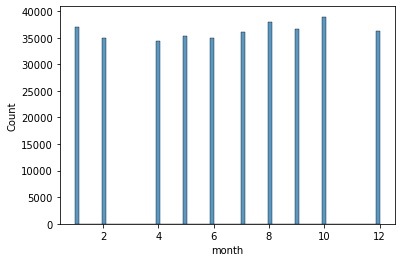

Column: day
------------------------


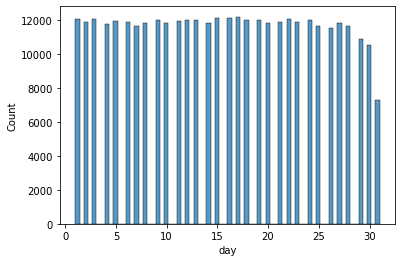

Column: year
------------------------


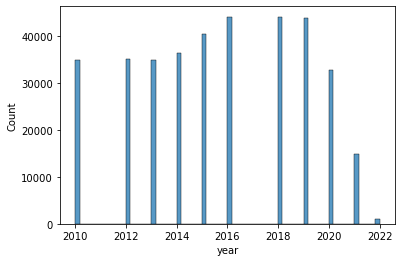

Column: hour
------------------------


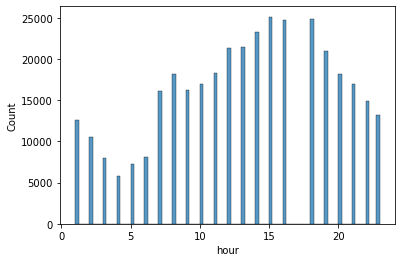

Column: lat
------------------------


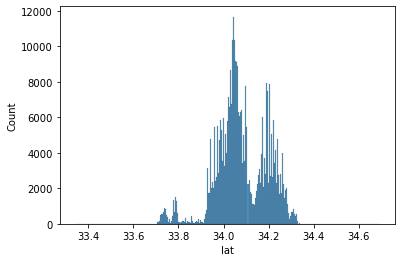

Column: long
------------------------


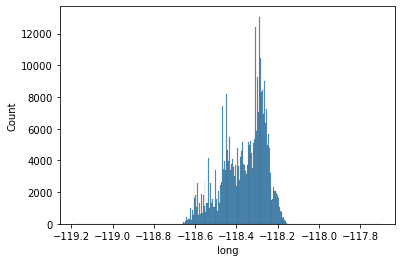

Column: label
------------------------
Cluster: 2
----------------
Column: Area ID
------------------------


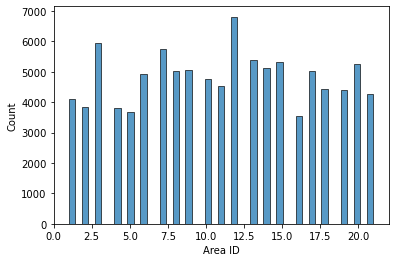

Column: Premise Description
------------------------
STREET              95902
PARKING LOT          3312
SIDEWALK              511
                      375
DRIVEWAY              195
                    ...  
METROLINK TRAIN         1
DEPARTMENT STORE        1
MINI-MART               1
CLOTHING STORE          1
OTHER RESIDENCE         1
Name: Premise Description, Length: 64, dtype: int64
Column: month
------------------------


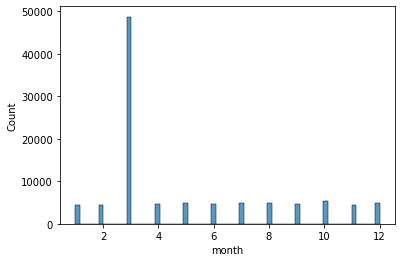

Column: day
------------------------


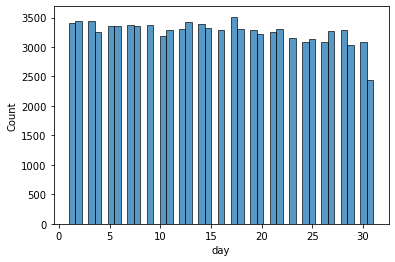

Column: year
------------------------


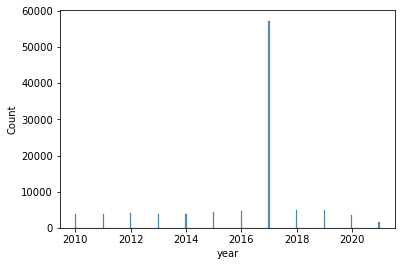

Column: hour
------------------------


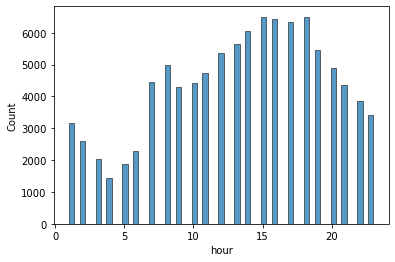

Column: lat
------------------------


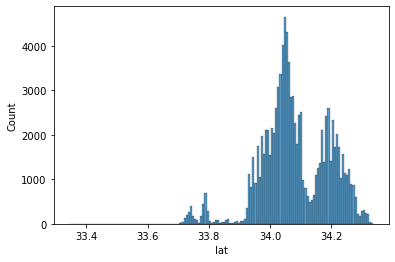

Column: long
------------------------


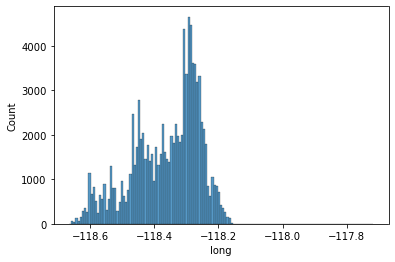

Column: label
------------------------


In [22]:
clusters = [c0, c1, c2]
for i, cluster in enumerate(clusters):
    print(f'Cluster: {i}')
    print('----------------')
    for col in cluster.columns:
        print(f'Column: {col}')
        print('------------------------')
        if col == 'Premise Description':
            print(cluster[col].value_counts())
        
        elif col == 'label':
            pass
        
        else:
            examine_labels(cluster, col)